In [21]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [22]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [23]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [24]:
from multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "BikeLQR-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

Process Process-24:
Process Process-28:
Process Process-32:
Process Process-19:
Process Process-27:
Process Process-31:
Process Process-29:
Traceback (most recent call last):
Process Process-23:
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-26:
Process Process-21:
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-20:
Process Process-17:
Traceback (most recent call last):
Process Process-30:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-25:
Traceback (most recent call last):
Process Process-18:
Process Process-22:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent

  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/albin/AutonomousBike2/AutonomousBike/PPO_notebook/multiprocessing_env.py", line 11, in worker
    cmd, data = remote.recv()
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/albin/anaconda3/envs/dml_proj/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/albin/Autonomo

<h2>Neural Network</h2>

In [25]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [26]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

def get_phi_sequence(state_0):
    state = state_0.copy()
    phi_sequence = [state[0]]
    action_sequence = [0]
    done = False
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        phi_sequence.append(next_state[0])
        action_sequence.append(action)
        state = next_state.copy()
    return phi_sequence, action_sequence

<h2>GAE</h2>

In [27]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [28]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [29]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 5e-5
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
#threshold_reward = -1.01
#threshold_reward = -0.16

#This reward is for training that does not 
#get interrupted until manually told to do so.
threshold_reward = 0

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
max_frames = int(3e5)
frame_idx  = 0
test_rewards = []

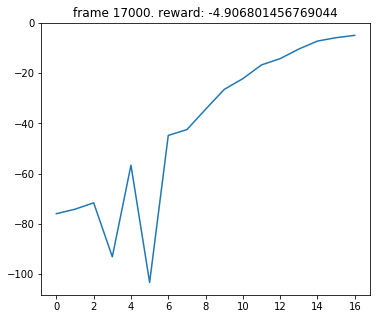

Rewards: [-75.94724177576595, -74.16748237703361, -71.62494401234446, -93.11356870171512, -56.637824613934754, -103.3413283441793, -44.772580710164746, -42.45093649717355, -34.36511426633865, -26.45414618541786, -22.140620863600642, -16.678017864380358, -14.180673464648724, -10.358970388168267, -7.182533536584427, -5.827719648749302, -4.906801456769044]


KeyboardInterrupt: 

In [31]:
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            print('Rewards:', test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

### Save and load network

In [11]:
# Save:
#torch.save(model.state_dict(), 'saved_networks/ppo_network')

# Load:
#model.load_state_dict(torch.load('saved_networks/ppo_network'))

#Load-v2:
#model.load_state_dict(torch.load('saved_networks/ppo_network_constant_initial_condition_1_hidden_256_nodes'))

<All keys matched successfully>

### Plot sequnce

51


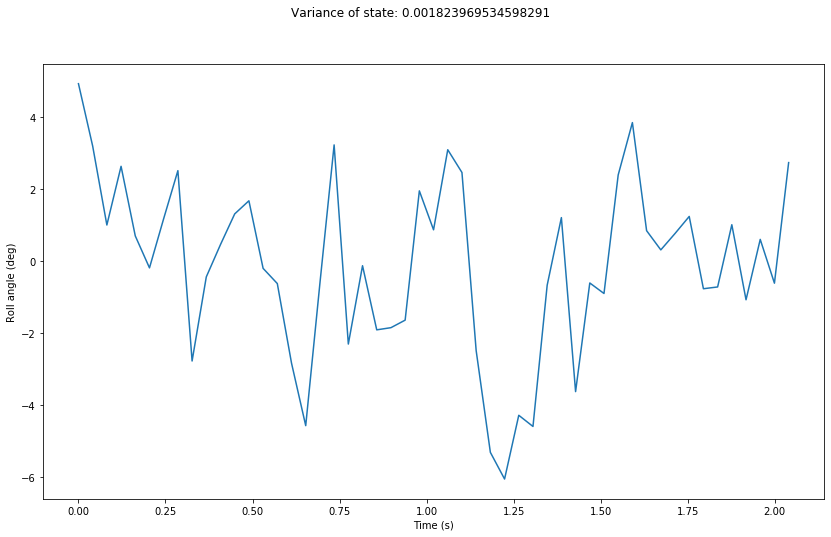

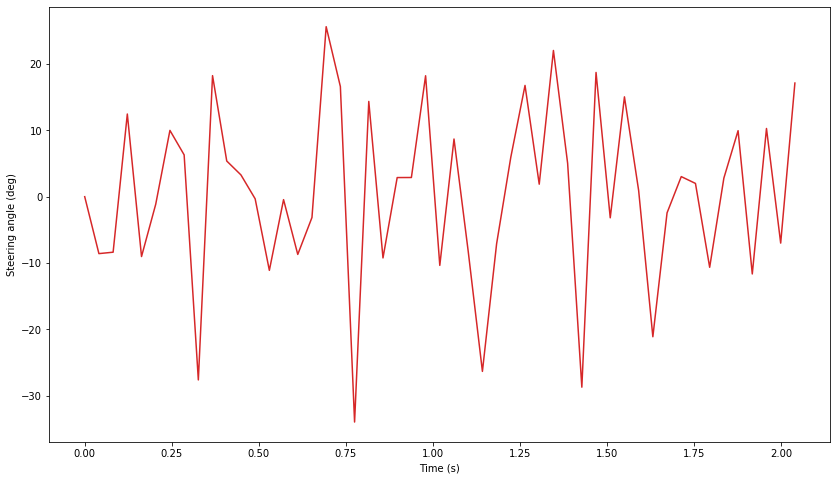

In [32]:
state_0 = env.reset()
state_0 = state_0
phi_sequence, action_sequence = get_phi_sequence(state_0)

Ts = 0.04
t = np.linspace(0, len(phi_sequence)*Ts, len(phi_sequence))
fig, ax1 = plt.subplots(figsize=(14,8))

#ax1.plot(t, np.array(phi_sequence)*180/np.pi)
#ax1.set_xlabel('Time (s)')
#ax1.set_ylabel('Roll angle (deg)')
variance_string = 'Variance of state: {}'.format(np.var(np.array(phi_sequence[20:])))
fig.suptitle(variance_string)

color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Roll angle (deg)')#, color=color)
ax1.plot(t, np.array(phi_sequence)*180/np.pi, color=color)
ax1.tick_params(axis='y')#, labelcolor=color)


fig, ax2 = plt.subplots(figsize=(14,8))

color = 'tab:red'
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Steering angle (deg)')#, color=color)  # we already handled the x-label with ax1
ax2.plot(t, np.array(action_sequence)*180/np.pi, color=color)
ax2.tick_params(axis='y')#, labelcolor=color)

<h1>Saving trajectories for GAIL</h1>

In [33]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -3.829967505424698
episode: 1 reward: -4.315284526739349
episode: 2 reward: -3.883120069370172
episode: 3 reward: -3.739036579124259
episode: 4 reward: -3.8087056864248163
episode: 5 reward: -3.5459373986129283
episode: 6 reward: -4.137398629757149
episode: 7 reward: -3.7811467788238775
episode: 8 reward: -2.9649072865169925
episode: 9 reward: -2.635884773643606
episode: 10 reward: -3.508913898826223
episode: 11 reward: -5.551000109879789
episode: 12 reward: -4.3898644754943525
episode: 13 reward: -3.4550716712091516
episode: 14 reward: -3.8375531387609603
episode: 15 reward: -4.643547437334849
episode: 16 reward: -4.0449837200117305
episode: 17 reward: -4.174661286733933
episode: 18 reward: -2.829864573080865
episode: 19 reward: -3.898018334969357
episode: 20 reward: -4.150095504103731
episode: 21 reward: -4.162568623038532
episode: 22 reward: -3.29303682938062
episode: 23 reward: -3.4975798843593826
episode: 24 reward: -2.69244088748279
episode: 25 reward: -4.39047

episode: 208 reward: -3.121618828601927
episode: 209 reward: -2.923343898709977
episode: 210 reward: -6.073306929021323
episode: 211 reward: -3.816569763902376
episode: 212 reward: -2.781889987984842
episode: 213 reward: -3.4074337373491046
episode: 214 reward: -3.0707636553560405
episode: 215 reward: -4.431096271677785
episode: 216 reward: -4.134021981842706
episode: 217 reward: -4.228664724309881
episode: 218 reward: -2.9692210663796743
episode: 219 reward: -3.3668801569889415
episode: 220 reward: -4.568372095869943
episode: 221 reward: -4.650781847649545
episode: 222 reward: -3.7031567461934407
episode: 223 reward: -3.4184646599427952
episode: 224 reward: -5.379941923976728
episode: 225 reward: -3.281012843124983
episode: 226 reward: -4.170029001558621
episode: 227 reward: -2.7722606759201236
episode: 228 reward: -4.2926421134577435
episode: 229 reward: -4.754914584470153
episode: 230 reward: -4.161325094380386
episode: 231 reward: -3.1935311178458052
episode: 232 reward: -4.1796771

episode: 422 reward: -4.0097182053752825
episode: 423 reward: -3.1203790989325033
episode: 424 reward: -3.3150598998723058
episode: 425 reward: -3.005276778279358
episode: 426 reward: -4.418020330209087
episode: 427 reward: -3.205942575390296
episode: 428 reward: -3.063323349075676
episode: 429 reward: -3.8333984259386513
episode: 430 reward: -4.802813542792702
episode: 431 reward: -4.507251172682533
episode: 432 reward: -3.645028890335203
episode: 433 reward: -3.937257221734429
episode: 434 reward: -3.598146341035484
episode: 435 reward: -5.707578944747454
episode: 436 reward: -3.9350501596893404
episode: 437 reward: -5.5349484680784995
episode: 438 reward: -3.3152157947409426
episode: 439 reward: -3.554121637014284
episode: 440 reward: -3.456536499019489
episode: 441 reward: -3.3307335348096947
episode: 442 reward: -2.668319094706772
episode: 443 reward: -4.092435000851918
episode: 444 reward: -2.8255358644640376
episode: 445 reward: -4.015634523373559
episode: 446 reward: -3.0282021

episode: 626 reward: -3.576759777704939
episode: 627 reward: -3.4671704699345467
episode: 628 reward: -3.9345785576054197
episode: 629 reward: -3.5758124948314025
episode: 630 reward: -3.8708968237657757
episode: 631 reward: -3.8675118539293845
episode: 632 reward: -2.2170089347777715
episode: 633 reward: -3.1316060720657273
episode: 634 reward: -4.4221401309401385
episode: 635 reward: -5.507801179529015
episode: 636 reward: -5.054241044231023
episode: 637 reward: -3.626521403016376
episode: 638 reward: -4.128911297044612
episode: 639 reward: -3.5769608453956616
episode: 640 reward: -3.37369643452779
episode: 641 reward: -3.8258697698313417
episode: 642 reward: -6.482767239394416
episode: 643 reward: -4.003978194875984
episode: 644 reward: -3.566858192462724
episode: 645 reward: -3.2113667315969403
episode: 646 reward: -2.1899034581339087
episode: 647 reward: -3.2639871294795304
episode: 648 reward: -3.5192000558999696
episode: 649 reward: -4.0252700688751935
episode: 650 reward: -5.02

episode: 830 reward: -3.1832009645747315
episode: 831 reward: -4.302998218780304
episode: 832 reward: -4.451220345963255
episode: 833 reward: -3.1443976074563125
episode: 834 reward: -3.4541038316084287
episode: 835 reward: -3.7157702633207434
episode: 836 reward: -3.569830663993337
episode: 837 reward: -3.5908979963873078
episode: 838 reward: -4.331510592493871
episode: 839 reward: -3.8582722036894337
episode: 840 reward: -2.834706461091172
episode: 841 reward: -4.408220739062841
episode: 842 reward: -5.100142408013091
episode: 843 reward: -4.55299855169541
episode: 844 reward: -5.130960244977306
episode: 845 reward: -3.6997471750968636
episode: 846 reward: -3.525036765021614
episode: 847 reward: -4.009009370218942
episode: 848 reward: -3.7187094063744297
episode: 849 reward: -3.638051083351791
episode: 850 reward: -2.6519477836307006
episode: 851 reward: -4.078525833528515
episode: 852 reward: -2.8928850962976433
episode: 853 reward: -4.0050014610957625
episode: 854 reward: -4.348191